**Hi! In this code I am implementing MNIST(handwritten digit recognition), using a basic neural network in PyTorch:**




1-Importing necessary libraries:

In [50]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from torch import nn
from tensorflow.keras.datasets import mnist
import mplcyberpunk

2-Loading the MNIST dataset, provided by **Keras**, **TensorFlow**:

In [51]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('x_train shape: ',x_train.shape,'  y_train shape: ',y_train.shape)
print('x_test shape: ',x_test.shape,'  y_test shape: ',y_test.shape)

x_train shape:  (60000, 28, 28)   y_train shape:  (60000,)
x_test shape:  (10000, 28, 28)   y_test shape:  (10000,)


3-Visualizing the dataset:

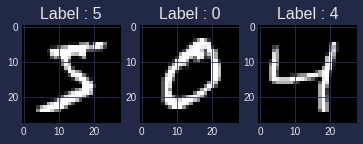

In [52]:
plt.style.use('cyberpunk')
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(x_train[i],cmap='gray')
    plt.title("Label : {}".format(y_train[i]),fontsize=16)
plt.show()

4-Normalizing x_train and x_test from **0-255** input values to **0-1**:

In [53]:
print('random row vector of x_train and x_test in raw format:')
first_index, second_index = np.random.choice(len(x_test)), np.random.randint(10,20)
print(x_test[first_index,second_index],'\nand\n',x_train[first_index,second_index])
print('\n\nrandom row vector of x_train and x_test after normalization:')
x_test, x_train = x_test/255, x_train/255
print(x_test[first_index,second_index],'\nand\n',x_train[first_index,second_index])

random row vector of x_train and x_test in raw format:
[  0   0   0   0   0   0   0   0   5 100 213 254 213 116   2   0   0   0
   0  30 187 254 235 211   4   0   0   0] 
and
 [  0   0   0   0 121 252 252 217 199  87  17   0   0   0   0   0 226 252
 252 163   0   0   0   0   0   0   0   0]


random row vector of x_train and x_test after normalization:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.01960784 0.39215686 0.83529412 0.99607843
 0.83529412 0.45490196 0.00784314 0.         0.         0.
 0.         0.11764706 0.73333333 0.99607843 0.92156863 0.82745098
 0.01568627 0.         0.         0.        ] 
and
 [0.         0.         0.         0.         0.4745098  0.98823529
 0.98823529 0.85098039 0.78039216 0.34117647 0.06666667 0.
 0.         0.         0.         0.         0.88627451 0.98823529
 0.98823529 0.63921569 0.         0.         0.         0.
 0.         0.         0.         0.        ]


5- Reshaping x_test and x_train from **(-1, 28, 28)**  to  **(-1, 784)**:

In [54]:
print('Before reshaping :',x_train.shape,x_test.shape)
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)
print('After reshaping :',x_train.shape,x_test.shape)

Before reshaping : (60000, 28, 28) (10000, 28, 28)
After reshaping : (60000, 784) (10000, 784)


6-Building the neural network with **4 layers**:

In [55]:
class MNIST_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.neuralNetwork = nn.Sequential(
            nn.Linear(784,128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(256,10),
            nn.Softmax()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.neuralNetwork(x)

7-Investigating the **Non-Trained** model on test data:

/home/amir/.local/lib/python3.10/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


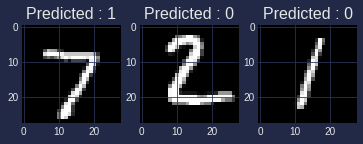

In [56]:
model = MNIST_Classifier()
with torch.inference_mode():
    y_pred = model(torch.Tensor(x_test))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(x_test[i].reshape(28,28),cmap='gray')
    plt.title("Predicted : {}".format(y_pred[i].argmax()),fontsize=16)
plt.show()

8- Importing **Optimizer**  and  **Loss Function**:


In [57]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
criterion = CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=0.01)

9- Creating **Tensors with prefered datatype**, making labels **one-hot** and enabling **gradient tracking**:

In [58]:
print('Does x_train track gradients: ',torch.Tensor(x_train).requires_grad)
x_train = torch.from_numpy(x_train).type(torch.float).requires_grad_()
x_test = torch.from_numpy(x_test).type(torch.float).requires_grad_()
print('\nDoes x_train track gradients: ',torch.Tensor(x_train).requires_grad)

y_test = torch.nn.functional.one_hot(torch.Tensor(y_test).type(torch.LongTensor), num_classes=10)
y_train = torch.nn.functional.one_hot(torch.Tensor(y_train).type(torch.LongTensor), num_classes=10)
y_train = y_train.type(torch.float).requires_grad_()
y_test = y_test.type(torch.float).requires_grad_()

Does x_train track gradients:  False

Does x_train track gradients:  True


9- Creating a **Cross Validation set** out of training set (10% of it):

In [59]:
x_CV = x_train[54000:]
y_CV = y_train[54000:]
print("shape of cross validation set:",x_CV.shape, y_CV.shape)
x_train = x_train[:54000]
y_train = y_train[:54000]
print("shape of new training set:",x_train.shape, y_train.shape)

shape of cross validation set: torch.Size([6000, 784]) torch.Size([6000, 10])
shape of new training set: torch.Size([54000, 784]) torch.Size([54000, 10])


10- Building a training loop and keeping the record of **loss** and **accuracy** for train and CV:

In [60]:
tic, toc = time.time(), time.time()
epochs, train_accuracy_list, train_loss_list = [], [], []
CV_loss_list, CV_accuracy_list = [], []

for epoch in range(151):
    
    model.train()
    y_pred = model(x_train).type(torch.float)
    loss = criterion(y_pred,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:  
        
        CV_y_pred = model(x_CV).type(torch.float)  
        CV_loss = criterion(CV_y_pred,y_CV)
        CV_loss_list.append(CV_loss.detach().numpy())  #loss for CV
        
        CV_correct = torch.eq(CV_y_pred.argmax(dim=-1),y_CV.argmax(dim=-1)).sum().item()
        CV_acc = (CV_correct / len(y_CV)) * 100
        CV_accuracy_list.append(CV_acc)                #accuracy for CV

        train_correct = torch.eq(y_pred.argmax(dim=-1),y_train.argmax(dim=-1)).sum().item()
        train_acc = (train_correct / len(y_train)) * 100
        train_accuracy_list.append(train_acc)          #accuracy for train
        
        train_loss_list.append(loss.detach().numpy())  #loss for train
                  
        epochs.append(epoch)
        
        toc = time.time()

        print(f'epoch #{epoch} | loss: {loss:.3f} | train accuracy: % {train_acc:.4f}',
              f'| CV accuracy: % {CV_acc:.4f} | spent time: {toc-tic:.2f} sec')
        
        tic = time.time()

epoch #0 | loss: 2.303 | train accuracy: % 12.6389 | CV accuracy: % 38.8167 | spent time: 2.69 sec
epoch #10 | loss: 2.096 | train accuracy: % 36.1685 | CV accuracy: % 37.2333 | spent time: 28.56 sec
epoch #20 | loss: 2.066 | train accuracy: % 38.9611 | CV accuracy: % 42.0500 | spent time: 28.43 sec
epoch #30 | loss: 1.992 | train accuracy: % 46.2648 | CV accuracy: % 48.1167 | spent time: 26.46 sec
epoch #40 | loss: 1.951 | train accuracy: % 50.7778 | CV accuracy: % 58.0833 | spent time: 25.86 sec
epoch #50 | loss: 1.791 | train accuracy: % 66.7093 | CV accuracy: % 71.8167 | spent time: 26.76 sec
epoch #60 | loss: 1.643 | train accuracy: % 81.7259 | CV accuracy: % 83.2167 | spent time: 25.34 sec
epoch #70 | loss: 1.534 | train accuracy: % 92.7593 | CV accuracy: % 94.0333 | spent time: 26.12 sec
epoch #80 | loss: 1.514 | train accuracy: % 94.7500 | CV accuracy: % 95.4833 | spent time: 26.76 sec
epoch #90 | loss: 1.504 | train accuracy: % 95.7667 | CV accuracy: % 96.1000 | spent time: 26

10- Taking out **the highest probablities** from predicted labels:

In [61]:
y_pred = model(x_test).type(torch.float)
print('the first prediction of x_test in raw format: \n', y_pred[0])
y_pred = y_pred.argmax(dim=-1)
print('the first prediction of x_test after argmax: \n', y_pred[0])

the first prediction of x_test in raw format: 
 tensor([9.2186e-23, 4.0895e-18, 2.8470e-15, 2.3243e-09, 3.2505e-25, 7.5446e-29,
        1.0285e-24, 1.0000e+00, 5.4806e-21, 3.7044e-15],
       grad_fn=<SelectBackward0>)
the first prediction of x_test after argmax: 
 tensor(7)


11- Checking a random example from **x_test**:

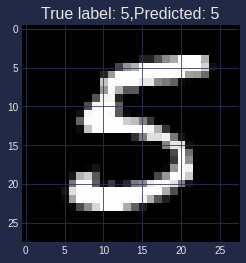

In [74]:
index = np.random.choice(len(x_test))
plt.imshow(x_test[index].detach().numpy().reshape(28,28),cmap='gray')
plt.title(f'True label: {y_test[index].argmax()},Predicted: {y_pred[index]:.0f}',fontsize=16)
plt.show()

12- Checking  **the accuracy** for the test set:

In [63]:
y_pred = y_pred.type(torch.float)
correct = torch.eq(y_pred, y_test.argmax(dim=-1).type(torch.float)).sum().item()
acc = (correct / len(y_test)) * 100
print(f'accuracy for the test set : % {acc}')

accuracy for the test set : % 96.47


13- Plotting the curves:

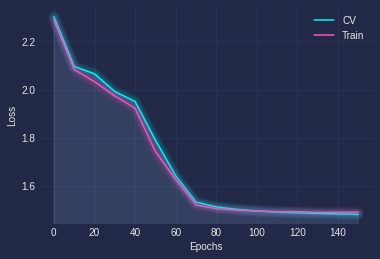

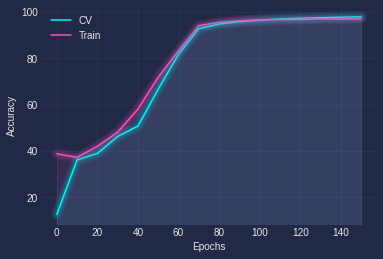

In [64]:
plt.plot(epochs,train_loss_list)
plt.plot(epochs,CV_loss_list)
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_underglow()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['CV','Train'])
plt.show()
plt.plot(epochs,train_accuracy_list)
plt.plot(epochs,CV_accuracy_list)
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_underglow()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['CV','Train'])
plt.show()